# CSC411 Assignment 3

In [2]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as mpimg
import os
import urllib
from copy import deepcopy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn import tree
import graphviz

## Global Helper Functions

In [3]:
def getNews(seed = 0):
    
    fakeFile = open("clean_fake.txt",'r')
    fakeNews = fakeFile.read().splitlines()
    fakeFile.close()
    realFile = open("clean_real.txt",'r')
    realNews = realFile.read().splitlines()
    realFile.close()
    
    np.random.shuffle(fakeNews)
    np.random.shuffle(realNews)
    
    return fakeNews, realNews

In [4]:
def dataSetSplit(fakeNews, realNews,seed = 0):
    
    trainingSet ={'real': realNews[:int(0.7*len(realNews))], 'fake':fakeNews[:int(0.7*len(fakeNews))]} 
    validationSet = {'real':realNews[int(0.7*len(realNews)):int(0.85*len(realNews))], 'fake':fakeNews[int(0.7*len(fakeNews)):int(0.85*len(fakeNews))]}
    testSet = {'real': realNews[int(0.85*len(realNews)):] , 'fake': fakeNews[int(0.85*len(fakeNews)):]}

    return trainingSet, validationSet, testSet

In [5]:
def generateWordBase(trainingSet):
    wordBase = []
    for rof in trainingSet.keys():
        for news in trainingSet[rof]:
            for word in news.split(' '):
                wordBase.append(word)
    return list(set(wordBase))

In [6]:
def count(trainingSet, validationSet, testSet):
    trainingCount = {'real':{}, 'fake':{}}
    validationCount = {'real':{}, 'fake':{}}
    testCount = {'real':{}, 'fake':{}}
    
    for rof in ['real','fake']:
        for news in trainingSet[rof]:
            for word in set(news.split(' ')):
                if not word in trainingCount[rof].keys():
                    trainingCount[rof][word] = 1
                else:
                    trainingCount[rof][word] += 1
        
        for news in validationSet[rof]:
            for word in set(news.split(' ')):
                if not word in validationCount[rof].keys():
                    validationCount[rof][word] = 1
                else:
                    validationCount[rof][word] += 1
        
        for news in testSet[rof]:
            for word in set(news.split(' ')):
                if not word in testCount[rof].keys():
                    testCount[rof][word] = 1
                else:
                    testCount[rof][word] += 1

    trainingRealCount = len(trainingSet['real'])
    trainingFakeCount = len(trainingSet['fake'])
    validationRealCount = len(validationSet['real'])
    validationFakeCount = len(validationSet['fake'])
    testRealCount = len(testSet['real'])
    testFakeCount = len(testSet['fake'])
    
    return trainingRealCount,trainingFakeCount,validationRealCount,validationFakeCount,testRealCount,testFakeCount, trainingCount, validationCount, testCount


## Part 1
Describe the datasets. You will be predicting whether a headline is real or fake news from words that appear in the headline. Is that feasible? Give 3 examples of specific keywords that may be useful, together with statistics on how often they appear in real and fake headlines.

Todo: dataset description

In [7]:
def part1(seed = 0):
    np.random.seed(seed)

    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    trainingRealCount,trainingFakeCount,validationRealCount, \
    validationFakeCount,testRealCount,testFakeCount, trainingCount, \
    validationCount, testCount = count(trainingSet, validationSet, testSet)
    
    words = []
    wordCountDiff = []
    
    for word in trainingCount['real']:
        words.append(word)
        wordCountDiff.append(trainingCount['real'][word])
    
    for word in trainingCount['fake']:
        if word in trainingCount['real']:
            wordCountDiff[words.index(word)] -= trainingCount['fake'][word]
        else:
            words.append(word)
            wordCountDiff.append(-(trainingCount['fake'][word]))
    
    realWord = []
    for i in range(3):
        realWord.append(words.pop(wordCountDiff.index(max(wordCountDiff))))
        wordCountDiff.remove(max(wordCountDiff))
    
    fakeWord = []
    for i in range(3):
        fakeWord.append(words.pop(wordCountDiff.index(min(wordCountDiff))))
        wordCountDiff.remove(min(wordCountDiff))
    
    print 'Three keywords that maybe useful for idcentifying real news: '+ str(realWord)
    print 'Three keywords that maybe useful for idcentifying fake news: '+ str(fakeWord)+'\n'
    
    for i in [realWord, fakeWord]:
        for word in i:
            print 'The word: '+ str(word)
            print 'occures in real news '+ str(trainingCount['real'][word]) + ' times'
            print 'occures in fake news '+ str(trainingCount['fake'][word]) + ' times'
            print 'difference is: ' + str(trainingCount['real'][word]-trainingCount['fake'][word]) + '\n'

In [9]:
part1()

Three keywords that maybe useful for idcentifying real news: ['donald', 'trump', 'trumps']
Three keywords that maybe useful for idcentifying fake news: ['the', 'hillary', 'a']

The word: donald
occures in real news 587 times
occures in fake news 156 times
difference is: 431

The word: trump
occures in real news 1218 times
occures in fake news 898 times
difference is: 320

The word: trumps
occures in real news 151 times
occures in fake news 3 times
difference is: 148

The word: the
occures in real news 126 times
occures in fake news 253 times
difference is: -127

The word: hillary
occures in real news 21 times
occures in fake news 97 times
difference is: -76

The word: a
occures in real news 66 times
occures in fake news 122 times
difference is: -56



## Helper Functions for Part 2

In [8]:
def probability(trainingRealCount,trainingFakeCount, trainingCount, m, pHat):
    trainingProbability = {'real': {}, 'fake': {}}
    for word in trainingCount['real'].keys():
        trainingProbability['real'][word] = (trainingCount['real'][word]+m*pHat)/float(trainingRealCount+m)
    for word in trainingCount['fake'].keys():
        trainingProbability['fake'][word] = (trainingCount['fake'][word]+m*pHat)/float(trainingFakeCount+m)
    
    realProbability = float(trainingRealCount)/(trainingRealCount+trainingFakeCount)
    fakeProbability = float(trainingFakeCount)/(trainingRealCount+trainingFakeCount)
    
    return trainingProbability, realProbability, fakeProbability

In [9]:
def getAccuracy(trainingProbability,realProbability, fakeProbability, targetSet, m, pHat):
    accuracy = 0
    for rof in ['real', 'fake']:
        for numNews in range(len(targetSet[rof])):
            logProb = 0   
            for word in trainingProbability['real'].keys():
                if word in targetSet[rof][numNews].split(' '):
                    logProb += log(trainingProbability['real'][word])
                else:
                    logProb += log(1-trainingProbability['real'][word])
            for word in targetSet[rof][numNews].split(' '):
                if not word in trainingProbability['real'].keys():
                    logProb += log(pHat)
            logProb += log(realProbability)
            realProb = logProb

            logProb = 0 
            for word in trainingProbability['fake'].keys():
                if word in targetSet[rof][numNews].split(' '):
                    logProb += log(trainingProbability['fake'][word])
                else:
                    logProb += log(1-trainingProbability['fake'][word])
            for word in targetSet[rof][numNews].split(' '):
                if not word in trainingProbability['fake'].keys():
                    logProb += log(pHat)
            logProb += log(fakeProbability)
            fakeProb = logProb
            
            if rof == 'real':
                if realProb > fakeProb:
                    accuracy += 1
            else:
                if realProb < fakeProb:
                    accuracy += 1
                    
    return accuracy / (float(len(targetSet['fake']))+float(len(targetSet['real'])))


In [10]:
def getProbability(trainingProbability,realProbability, fakeProbability, wordBase, m, pHat):
    words = []
    realPresence = [] # real-fake
    realAbsence = []
    fakeAbsence = [] # real-fake
    fakePresence = []
    
    for testWord in wordBase:
        if testWord in trainingProbability['real'].keys():
            realPresenceLogProb = log(trainingProbability['real'][testWord]) + log(realProbability)
            realAbsenceLogProb = log(1-trainingProbability['real'][testWord]) + log(realProbability)
        else: 
            realPresenceLogProb = log(pHat) + log(realProbability)
            realAbsenceLogProb = log(1-pHat) + log(realProbability)
            
        if testWord in trainingProbability['fake'].keys():
            fakePresenceLogProb = log(trainingProbability['fake'][testWord]) + log(fakeProbability)
            fakeAbsenceLogProb = log(1-trainingProbability['fake'][testWord]) + log(fakeProbability)
        else:
            fakePresenceLogProb = log(pHat) + log(fakeProbability)
            fakeAbsenceLogProb = log(1-pHat) + log(fakeProbability)
        
        words.append(testWord)
        realPresence.append(exp(realPresenceLogProb)/(exp(realPresenceLogProb)+exp(fakePresenceLogProb)))
        fakePresence.append(exp(fakePresenceLogProb)/(exp(realPresenceLogProb)+exp(fakePresenceLogProb)))
        realAbsence.append(exp(realAbsenceLogProb)/(exp(realAbsenceLogProb)+exp(fakeAbsenceLogProb)))
        fakeAbsence.append(exp(fakeAbsenceLogProb)/(exp(realAbsenceLogProb)+exp(fakeAbsenceLogProb)))
    
    return words, realPresence, realAbsence, fakeAbsence, fakePresence

## Part 2
Todo: 这个part基本写完了 tune 的part我打算做一个contour plot 但是不知道效果会是什么样的 run这个比较花时间 之后再说

In [11]:
def part2(seed = 0):
    np.random.seed(seed)

    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    trainingRealCount,trainingFakeCount,validationRealCount, \
    validationFakeCount,testRealCount,testFakeCount, trainingCount, \
    validationCount, testCount = count(trainingSet, validationSet, testSet)
    
    m = 150
    pHat = 0.02
    CMax = 0
    
    
    ms = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
    pHats = np.array([0.0001, 0.001,0.005, 0.01, 0.05])
    
    C = np.zeros([ms.size, pHats.size])
    for i, w1 in enumerate(ms):
        for j, w2 in enumerate(pHats):
            trainingProbability, realProbability, fakeProbability = probability(trainingRealCount,trainingFakeCount, trainingCount, w1,w2)
            C[i,j] = getAccuracy(trainingProbability,realProbability, fakeProbability, validationSet, w1, w2)
            if C[i,j] > CMax:
                CMax = C[i,j]
                m = w1
                pHat = w2
    
    mz, pHatz = np.meshgrid(ms, pHats)
    CS = plt.contour(mz, pHatz, C)
    plt.clabel(CS)
    plt.legend(loc='upper left')
    plt.title('Contour plot')
    plt.show()
    
    
    trainingProbability, realProbability, fakeProbability = probability(trainingRealCount,trainingFakeCount, trainingCount, m,pHat)
    
    print 'Finally we choose: '
    print 'm =', (m)
    print 'pHat =', (pHat)
    print 'Performance on validation set is',(getAccuracy(trainingProbability,realProbability, fakeProbability, validationSet, m, pHat))
    print 'Performance on test set is', (getAccuracy(trainingProbability,realProbability, fakeProbability, testSet, m, pHat))
    print 'Performance on training set is',(getAccuracy(trainingProbability,realProbability, fakeProbability, trainingSet, m, pHat))

In [ ]:
part2()

## Part 3

### Part3 a)
Naive version 直接根据count多少算conditional probability，正式的version算的是MAP， 用后面出来的结果就好

有一点不清楚的是MAP出来的结果里面没有stopping words

In [14]:
def part3a(seed = 0):
    np.random.seed(0)

    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    trainingRealCount,trainingFakeCount,validationRealCount, \
    validationFakeCount,testRealCount,testFakeCount, trainingCount, \
    validationCount, testCount = count(trainingSet, validationSet, testSet)

    m = 0.1
    pHat = 0.0001
    trainingProbability, realProbability, fakeProbability = \
    probability(trainingRealCount,trainingFakeCount, trainingCount, m,pHat)

    wordBase = generateWordBase(trainingSet)
    wordsOriginal, realPresence, realAbsence, fakeAbsence, fakePresence = getProbability(trainingProbability,realProbability, fakeProbability, wordBase, m, pHat)
    
    words = deepcopy(wordsOriginal)
    realResultMax = []
    for i in range(10):
        realResultMax.append(words.pop(realPresence.index(max(realPresence))))
        realPresence.remove(max(realPresence))

    words = deepcopy(wordsOriginal)
    realResultMin = []
    for i in range(10):
        realResultMin.append(words.pop(realAbsence.index(max(realAbsence))))
        realAbsence.remove(max(realAbsence))
    
    words = deepcopy(wordsOriginal)
    fakeResultMax = []
    for i in range(10):
        fakeResultMax.append(words.pop(fakePresence.index(max(fakePresence))))
        fakePresence.remove(max(fakePresence))
        
    words = deepcopy(wordsOriginal)
    fakeResultMin = []
    for i in range(10):
        fakeResultMin.append(words.pop(fakeAbsence.index(max(fakeAbsence))))
        fakeAbsence.remove(max(fakeAbsence))
    
    
    print 'Words whose presence strongly predicts that the news is real:\n', realResultMax
    print 'Words whose absence strongly predicts that the news is real:\n', realResultMin
    print 'Words whose presence strongly predicts that the news is fake:\n', fakeResultMax
    print 'Words whose absence strongly predicts that the news is fake:\n', fakeResultMin

In [15]:
part3a()

Words whose presence strongly predicts that the news is real:
['korea', 'turnbull', 'travel', 'australia', 'trade', 'refugee', 'paris', 'tax', 'debate', 'defends']
Words whose absence strongly predicts that the news is real:
['trump', 'the', 'to', 'hillary', 'a', 'is', 'for', 'and', 'clinton', 'of']
Words whose presence strongly predicts that the news is fake:
['breaking', '3', 'soros', 'u', 'daily', 'woman', 'reason', 'steal', 'endingfed', 'these']
Words whose absence strongly predicts that the news is fake:
['donald', 'trumps', 'us', 'says', 'ban', 'north', 'korea', 'turnbull', 'travel', 'australia']


### Part 3 b)

In [16]:
def part3b(seed = 0):
    np.random.seed(0)
    
    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    trainingRealCount,trainingFakeCount,validationRealCount, \
    validationFakeCount,testRealCount,testFakeCount, trainingCount, \
    validationCount, testCount = count(trainingSet, validationSet, testSet)

    m = 0.1
    pHat = 0.0001
    trainingProbability, realProbability, fakeProbability = \
    probability(trainingRealCount,trainingFakeCount, trainingCount, m,pHat)

    wordBase = generateWordBase(trainingSet)
    
    for word in ENGLISH_STOP_WORDS:
        if word in wordBase:
            wordBase.remove(word)
    
    wordsOriginal, realPresence, realAbsence, fakeAbsence, fakePresence = getProbability(trainingProbability,realProbability, fakeProbability, wordBase, m, pHat)
    
    words = deepcopy(wordsOriginal)
    realResultMax = []
    for i in range(10):
        realResultMax.append(words.pop(realPresence.index(max(realPresence))))
        realPresence.remove(max(realPresence))

    words = deepcopy(wordsOriginal)
    realResultMin = []
    for i in range(10):
        realResultMin.append(words.pop(realAbsence.index(max(realAbsence))))
        realAbsence.remove(max(realAbsence))
    
    words = deepcopy(wordsOriginal)
    fakeResultMax = []
    for i in range(10):
        fakeResultMax.append(words.pop(fakePresence.index(max(fakePresence))))
        fakePresence.remove(max(fakePresence))
        
    words = deepcopy(wordsOriginal)
    fakeResultMin = []
    for i in range(10):
        fakeResultMin.append(words.pop(fakeAbsence.index(max(fakeAbsence))))
        fakeAbsence.remove(max(fakeAbsence))
    
    
    print 'Words whose presence strongly predicts that the news is real:\n', realResultMax
    print 'Words whose absence strongly predicts that the news is real:\n', realResultMin
    print 'Words whose presence strongly predicts that the news is fake:\n', fakeResultMax
    print 'Words whose absence strongly predicts that the news is fake:\n', fakeResultMin

In [17]:
part3b()

Words whose presence strongly predicts that the news is real:
['korea', 'turnbull', 'travel', 'australia', 'trade', 'refugee', 'paris', 'tax', 'debate', 'defends']
Words whose absence strongly predicts that the news is real:
['trump', 'hillary', 'clinton', 'just', 'obama', 'new', 'news', 'america', 'supporter', 'campaign']
Words whose presence strongly predicts that the news is fake:
['breaking', '3', 'soros', 'u', 'daily', 'woman', 'reason', 'steal', 'endingfed', 'd']
Words whose absence strongly predicts that the news is fake:
['donald', 'trumps', 'says', 'ban', 'north', 'korea', 'turnbull', 'travel', 'australia', 'china']


## Helper Functions for Part 4

In [24]:
def generateData(wordBase, targetSet):
    xy = np.zeros([len(wordBase)+2, (len(targetSet['real'])+len(targetSet['fake']))])
    n = 0
    for rof in ['real', 'fake']:
        for news in targetSet[rof]:
            for word in news.split(' '):
                if word in wordBase:
                    xy[wordBase.index(word),n] = 1
            if rof == 'real':
                xy[-1,n] = 1
            n += 1
    xy[-2,:] = 1
    return xy

In [25]:
def sigmoidForward(y):
    return 1/(1+exp(-y))

def fcForward(x,W):
    return np.matmul(W.T,x)
    
def forward(x, W):
    L1 = fcForward(x,W)
    output = sigmoidForward(L1)
    return output

def sigmoidBackward(y,output):
    return output-y

def fcBackward(dy,x):
    dW = np.matmul(x,dy.T)
    return dW

def backward(y,output,x, W, lam):
    dy = sigmoidBackward(y,output)
    dW = fcBackward(dy,x)
    dWR = 2*lam*W
    return dW + dWR

def NLL(y,output, lam, W):
    return -sum(y*log(output)+(1-y)*log((1-output)))+ lam*np.matmul(W.T,W)

In [27]:
def performance(x, y, W, print_output = False,report = "test set"):
    output = forward(x,W)
    result = 0.

    for i in range(x.shape[1]):
        if (output[0,i]>0.5 and y[i]==1):
            result+=1
        elif (output[0,i]<0.5 and y[i]==0):
            result += 1
            
    if print_output:
        print "Performance on "+report+ ": " +str(result)+"/"+str(x.shape[1])+"\n"
    
    return result/x.shape[1]

In [28]:
def grad_descent(f, df, loss, x, y, init_t,training_xy,validation_xy,test_xy, lam = 0.0001, alpha=0.0001, max_iter=50, EPS = 1e-5, learningCurve = True):
    v = np.zeros((init_t.shape[0],init_t.shape[1])) #used for momentum
    prev_t = init_t-10*EPS
    t = init_t.copy()
    
    iter  = 0
    
    num_iter = []
    performance_training = []
    performance_validation = []
    performance_test = []
    loss_training = []
    loss_validation = []
    loss_test = []
    
    
    while norm(t - prev_t) >  EPS and iter < max_iter:
        
        #normal gradient descent
        prev_t = t.copy()
        t -= alpha*df(y, f(x,t), x, t, lam)
        
        if iter % 5 == 0:
            print "Iter", iter
            print loss(y, f(x,t),lam, t)
            num_iter.append(iter)
            
            performance_training.append(performance(training_xy[:-1,:], training_xy[-1,:], t))
            performance_validation.append(performance(validation_xy[:-1,:], validation_xy[-1,:], t))
            performance_test.append(performance(test_xy[:-1,:], test_xy[-1,:], t))
            
            loss_training.append(loss(training_xy[-1,:], f(training_xy[:-1,:],t),lam, t)[0,0])
            loss_validation.append(loss(validation_xy[-1,:], f(validation_xy[:-1,:],t),lam, t)[0,0])
            loss_test.append(loss(test_xy[-1,:], f(test_xy[:-1,:],t),lam, t)[0,0])
        
        iter += 1
        
    if learningCurve:
        
        figure(1)
        plt.plot(num_iter, performance_training,'-')
        plt.plot(num_iter, performance_validation,'-')
        plt.plot(num_iter, performance_test,'-')
        plt.legend(['training', 'validation', 'test'])
        plt.xlabel('Number of Iterations')
        plt.ylabel('Performance')
        plt.show()
        
        figure(2)
        plt.plot(num_iter, loss_training,'-')
        plt.plot(num_iter, loss_validation,'-')
        plt.plot(num_iter, loss_test,'-')
        plt.legend(['training', 'validation', 'test'])
        plt.xlabel('Number of Iterations')
        plt.ylabel('Loss')
        plt.show()
    
    return t

## Part 4
L2 regularization

In [31]:
def part4(seed = 0, printResult = True):
    np.random.seed(seed)
    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    wordBase = generateWordBase(trainingSet)
    
    training_xy = generateData(wordBase, trainingSet)
    validation_xy = generateData(wordBase, validationSet)
    test_xy = generateData(wordBase, testSet)
    
    W = np.random.normal(0.,0.,[len(wordBase)+1,1])
    trainedW = grad_descent(forward, backward, NLL, training_xy[:-1,:], training_xy[-1,:], W, training_xy,validation_xy, test_xy, max_iter=5000)
    
    if printResult:
        print performance(training_xy[:-1,:], training_xy[-1,:], trainedW, print_output = True,report = "training set")
        print performance(validation_xy[:-1,:], validation_xy[-1,:], trainedW, print_output = True,report = "training set")
        print performance(test_xy[:-1,:], test_xy[-1,:], trainedW, print_output = True,report = "training set")
    
    return wordBase, trainedW

Iter 0
[[1568.2870164]]
Iter 5
[[1514.85753251]]
Iter 10
[[1479.34284813]]
Iter 15
[[1450.26704403]]
Iter 20
[[1424.51869495]]
Iter 25
[[1401.11375902]]
Iter 30
[[1379.63267262]]
Iter 35
[[1359.82109486]]
Iter 40
[[1341.48511876]]
Iter 45
[[1324.46215924]]
Iter 50
[[1308.61154778]]
Iter 55
[[1293.8103945]]
Iter 60
[[1279.95098451]]
Iter 65
[[1266.93874145]]
Iter 70
[[1254.690501]]
Iter 75
[[1243.13301601]]
Iter 80
[[1232.20165872]]
Iter 85
[[1221.83929578]]
Iter 90
[[1211.99531507]]
Iter 95
[[1202.62478503]]
Iter 100
[[1193.68772901]]
Iter 105
[[1185.148499]]
Iter 110
[[1176.975235]]
Iter 115
[[1169.13939792]]
Iter 120
[[1161.61536569]]
Iter 125
[[1154.38008356]]
Iter 130
[[1147.41276088]]
Iter 135
[[1140.69460782]]
Iter 140
[[1134.20860629]]
Iter 145
[[1127.93931044]]
Iter 150
[[1121.87267238]]
Iter 155
[[1115.99588986]]
Iter 160
[[1110.29727277]]
Iter 165
[[1104.7661259]]
Iter 170
[[1099.39264588]]
Iter 175
[[1094.16783035]]
Iter 180
[[1089.08339769]]
Iter 185
[[1084.13171611]]
Iter 

Iter 1570
[[663.03726872]]
Iter 1575
[[662.35960294]]
Iter 1580
[[661.68400896]]
Iter 1585
[[661.01047452]]
Iter 1590
[[660.33898748]]
Iter 1595
[[659.6695358]]
Iter 1600
[[659.00210756]]
Iter 1605
[[658.33669093]]
Iter 1610
[[657.67327419]]
Iter 1615
[[657.01184572]]
Iter 1620
[[656.35239402]]
Iter 1625
[[655.69490767]]
Iter 1630
[[655.03937535]]
Iter 1635
[[654.38578584]]
Iter 1640
[[653.73412803]]
Iter 1645
[[653.08439089]]
Iter 1650
[[652.4365635]]
Iter 1655
[[651.79063501]]
Iter 1660
[[651.14659469]]
Iter 1665
[[650.50443188]]
Iter 1670
[[649.86413602]]
Iter 1675
[[649.22569664]]
Iter 1680
[[648.58910337]]
Iter 1685
[[647.95434589]]
Iter 1690
[[647.32141401]]
Iter 1695
[[646.6902976]]
Iter 1700
[[646.06098661]]
Iter 1705
[[645.43347111]]
Iter 1710
[[644.80774121]]
Iter 1715
[[644.18378711]]
Iter 1720
[[643.56159912]]
Iter 1725
[[642.9411676]]
Iter 1730
[[642.322483]]
Iter 1735
[[641.70553585]]
Iter 1740
[[641.09031674]]
Iter 1745
[[640.47681637]]
Iter 1750
[[639.86502548]]
Iter 17

Iter 3095
[[517.67480873]]
Iter 3100
[[517.33000608]]
Iter 3105
[[516.98577703]]
Iter 3110
[[516.64211981]]
Iter 3115
[[516.29903265]]
Iter 3120
[[515.95651381]]
Iter 3125
[[515.61456154]]
Iter 3130
[[515.27317412]]
Iter 3135
[[514.9323498]]
Iter 3140
[[514.59208688]]
Iter 3145
[[514.25238363]]
Iter 3150
[[513.91323837]]
Iter 3155
[[513.57464938]]
Iter 3160
[[513.23661499]]
Iter 3165
[[512.89913351]]
Iter 3170
[[512.56220328]]
Iter 3175
[[512.22582262]]
Iter 3180
[[511.88998987]]
Iter 3185
[[511.5547034]]
Iter 3190
[[511.21996156]]
Iter 3195
[[510.88576271]]
Iter 3200
[[510.55210523]]
Iter 3205
[[510.21898749]]
Iter 3210
[[509.88640789]]
Iter 3215
[[509.55436481]]
Iter 3220
[[509.22285667]]
Iter 3225
[[508.89188186]]
Iter 3230
[[508.56143881]]
Iter 3235
[[508.23152595]]
Iter 3240
[[507.90214169]]
Iter 3245
[[507.57328448]]
Iter 3250
[[507.24495276]]
Iter 3255
[[506.91714499]]
Iter 3260
[[506.58985961]]
Iter 3265
[[506.26309511]]
Iter 3270
[[505.93684995]]
Iter 3275
[[505.6111226]]
Iter

Iter 4630
[[432.49830718]]
Iter 4635
[[432.27325907]]
Iter 4640
[[432.04847598]]
Iter 4645
[[431.82395734]]
Iter 4650
[[431.59970263]]
Iter 4655
[[431.37571129]]
Iter 4660
[[431.15198277]]
Iter 4665
[[430.92851653]]
Iter 4670
[[430.70531205]]
Iter 4675
[[430.48236876]]
Iter 4680
[[430.25968615]]
Iter 4685
[[430.03726366]]
Iter 4690
[[429.81510078]]
Iter 4695
[[429.59319697]]
Iter 4700
[[429.37155169]]
Iter 4705
[[429.15016442]]
Iter 4710
[[428.92903462]]
Iter 4715
[[428.70816179]]
Iter 4720
[[428.48754538]]
Iter 4725
[[428.26718489]]
Iter 4730
[[428.04707978]]
Iter 4735
[[427.82722954]]
Iter 4740
[[427.60763365]]
Iter 4745
[[427.3882916]]
Iter 4750
[[427.16920287]]
Iter 4755
[[426.95036695]]
Iter 4760
[[426.73178332]]
Iter 4765
[[426.51345149]]
Iter 4770
[[426.29537093]]
Iter 4775
[[426.07754115]]
Iter 4780
[[425.85996163]]
Iter 4785
[[425.64263188]]
Iter 4790
[[425.42555139]]
Iter 4795
[[425.20871966]]
Iter 4800
[[424.9921362]]
Iter 4805
[[424.7758005]]
Iter 4810
[[424.55971207]]
Iter

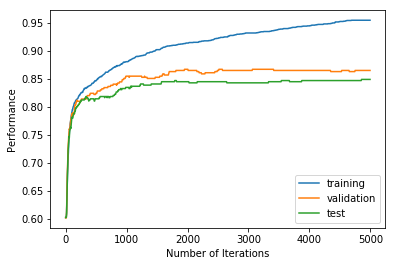

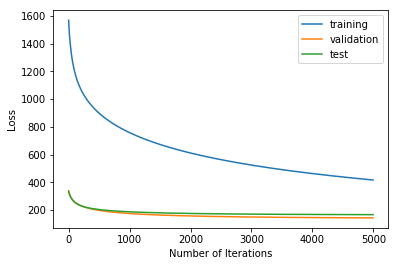

Performance on training set: 2183.0/2285

0.955361050328
Performance on training set: 424.0/490

0.865306122449
Performance on training set: 417.0/491

0.849287169043


In [32]:
wordBase, trainedW = part4()

## Part 5
Todo: todo

## Part 6

### Part 6 a)

In [33]:
def part6a(seed = 0):
    wordBase, trainedW = part4(seed=seed, printResult = False)
    
    wordsList = deepcopy(wordBase)
    weightList = deepcopy(trainedW.tolist()[:-1])
    realResultMax = []
    for i in range(10):
        realResultMax.append(wordsList.pop(weightList.index(max(weightList))))
        weightList.remove(max(weightList))

    fakeResultMax = []
    for i in range(10):
        fakeResultMax.append(wordsList.pop(weightList.index(min(weightList))))
        weightList.remove(min(weightList))
    
    print "Top 10 positive thetas are:\n", realResultMax
    print "Top 10 negative thetas are:\n", fakeResultMax
    

Iter 0
[[1568.2870164]]
Iter 5
[[1514.85753251]]
Iter 10
[[1479.34284813]]
Iter 15
[[1450.26704403]]
Iter 20
[[1424.51869495]]
Iter 25
[[1401.11375902]]
Iter 30
[[1379.63267262]]
Iter 35
[[1359.82109486]]
Iter 40
[[1341.48511876]]
Iter 45
[[1324.46215924]]
Iter 50
[[1308.61154778]]
Iter 55
[[1293.8103945]]
Iter 60
[[1279.95098451]]
Iter 65
[[1266.93874145]]
Iter 70
[[1254.690501]]
Iter 75
[[1243.13301601]]
Iter 80
[[1232.20165872]]
Iter 85
[[1221.83929578]]
Iter 90
[[1211.99531507]]
Iter 95
[[1202.62478503]]
Iter 100
[[1193.68772901]]
Iter 105
[[1185.148499]]
Iter 110
[[1176.975235]]
Iter 115
[[1169.13939792]]
Iter 120
[[1161.61536569]]
Iter 125
[[1154.38008356]]
Iter 130
[[1147.41276088]]
Iter 135
[[1140.69460782]]
Iter 140
[[1134.20860629]]
Iter 145
[[1127.93931044]]
Iter 150
[[1121.87267238]]
Iter 155
[[1115.99588986]]
Iter 160
[[1110.29727277]]
Iter 165
[[1104.7661259]]
Iter 170
[[1099.39264588]]
Iter 175
[[1094.16783035]]
Iter 180
[[1089.08339769]]
Iter 185
[[1084.13171611]]
Iter 

Iter 1565
[[663.71701866]]
Iter 1570
[[663.03726872]]
Iter 1575
[[662.35960294]]
Iter 1580
[[661.68400896]]
Iter 1585
[[661.01047452]]
Iter 1590
[[660.33898748]]
Iter 1595
[[659.6695358]]
Iter 1600
[[659.00210756]]
Iter 1605
[[658.33669093]]
Iter 1610
[[657.67327419]]
Iter 1615
[[657.01184572]]
Iter 1620
[[656.35239402]]
Iter 1625
[[655.69490767]]
Iter 1630
[[655.03937535]]
Iter 1635
[[654.38578584]]
Iter 1640
[[653.73412803]]
Iter 1645
[[653.08439089]]
Iter 1650
[[652.4365635]]
Iter 1655
[[651.79063501]]
Iter 1660
[[651.14659469]]
Iter 1665
[[650.50443188]]
Iter 1670
[[649.86413602]]
Iter 1675
[[649.22569664]]
Iter 1680
[[648.58910337]]
Iter 1685
[[647.95434589]]
Iter 1690
[[647.32141401]]
Iter 1695
[[646.6902976]]
Iter 1700
[[646.06098661]]
Iter 1705
[[645.43347111]]
Iter 1710
[[644.80774121]]
Iter 1715
[[644.18378711]]
Iter 1720
[[643.56159912]]
Iter 1725
[[642.9411676]]
Iter 1730
[[642.322483]]
Iter 1735
[[641.70553585]]
Iter 1740
[[641.09031674]]
Iter 1745
[[640.47681637]]
Iter 17

Iter 3110
[[516.64211981]]
Iter 3115
[[516.29903265]]
Iter 3120
[[515.95651381]]
Iter 3125
[[515.61456154]]
Iter 3130
[[515.27317412]]
Iter 3135
[[514.9323498]]
Iter 3140
[[514.59208688]]
Iter 3145
[[514.25238363]]
Iter 3150
[[513.91323837]]
Iter 3155
[[513.57464938]]
Iter 3160
[[513.23661499]]
Iter 3165
[[512.89913351]]
Iter 3170
[[512.56220328]]
Iter 3175
[[512.22582262]]
Iter 3180
[[511.88998987]]
Iter 3185
[[511.5547034]]
Iter 3190
[[511.21996156]]
Iter 3195
[[510.88576271]]
Iter 3200
[[510.55210523]]
Iter 3205
[[510.21898749]]
Iter 3210
[[509.88640789]]
Iter 3215
[[509.55436481]]
Iter 3220
[[509.22285667]]
Iter 3225
[[508.89188186]]
Iter 3230
[[508.56143881]]
Iter 3235
[[508.23152595]]
Iter 3240
[[507.90214169]]
Iter 3245
[[507.57328448]]
Iter 3250
[[507.24495276]]
Iter 3255
[[506.91714499]]
Iter 3260
[[506.58985961]]
Iter 3265
[[506.26309511]]
Iter 3270
[[505.93684995]]
Iter 3275
[[505.6111226]]
Iter 3280
[[505.28591156]]
Iter 3285
[[504.96121532]]
Iter 3290
[[504.63703237]]
Iter

Iter 4655
[[431.37571129]]
Iter 4660
[[431.15198277]]
Iter 4665
[[430.92851653]]
Iter 4670
[[430.70531205]]
Iter 4675
[[430.48236876]]
Iter 4680
[[430.25968615]]
Iter 4685
[[430.03726366]]
Iter 4690
[[429.81510078]]
Iter 4695
[[429.59319697]]
Iter 4700
[[429.37155169]]
Iter 4705
[[429.15016442]]
Iter 4710
[[428.92903462]]
Iter 4715
[[428.70816179]]
Iter 4720
[[428.48754538]]
Iter 4725
[[428.26718489]]
Iter 4730
[[428.04707978]]
Iter 4735
[[427.82722954]]
Iter 4740
[[427.60763365]]
Iter 4745
[[427.3882916]]
Iter 4750
[[427.16920287]]
Iter 4755
[[426.95036695]]
Iter 4760
[[426.73178332]]
Iter 4765
[[426.51345149]]
Iter 4770
[[426.29537093]]
Iter 4775
[[426.07754115]]
Iter 4780
[[425.85996163]]
Iter 4785
[[425.64263188]]
Iter 4790
[[425.42555139]]
Iter 4795
[[425.20871966]]
Iter 4800
[[424.9921362]]
Iter 4805
[[424.7758005]]
Iter 4810
[[424.55971207]]
Iter 4815
[[424.34387042]]
Iter 4820
[[424.12827505]]
Iter 4825
[[423.91292548]]
Iter 4830
[[423.6978212]]
Iter 4835
[[423.48296174]]
Iter 

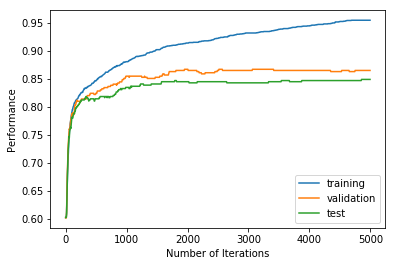

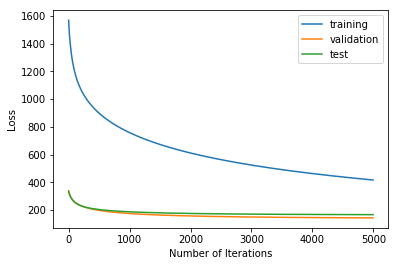

Top 10 positive thetas are:
['trumps', 'us', 'turnbull', 'north', 'australia', 'donald', 'debate', 'says', 'trade', 'tax']
Top 10 negative thetas are:
['victory', 'hillary', 'breaking', 'supporter', 'are', 'just', 'watch', 'that', 'black', 'voter']


In [34]:
part6a()

### Part 6 b)

In [35]:
def part6b(seed = 0):
    wordBase, trainedW = part4(seed=seed, printResult = False)
    
    wordsList = deepcopy(wordBase)
    weightList = deepcopy(trainedW.tolist()[:-1])
    
    for word in ENGLISH_STOP_WORDS:
        if word in wordsList:
            weightList.pop(wordsList.index(word))
            wordsList.remove(word)
    
    realResultMax = []
    for i in range(10):
        realResultMax.append(wordsList.pop(weightList.index(max(weightList))))
        weightList.remove(max(weightList))

    fakeResultMax = []
    for i in range(10):
        fakeResultMax.append(wordsList.pop(weightList.index(min(weightList))))
        weightList.remove(min(weightList))

    print "Top 10 positive thetas are:\n", realResultMax
    print "Top 10 negative thetas are:\n", fakeResultMax
    

Iter 0
[[1568.2870164]]
Iter 5
[[1514.85753251]]
Iter 10
[[1479.34284813]]
Iter 15
[[1450.26704403]]
Iter 20
[[1424.51869495]]
Iter 25
[[1401.11375902]]
Iter 30
[[1379.63267262]]
Iter 35
[[1359.82109486]]
Iter 40
[[1341.48511876]]
Iter 45
[[1324.46215924]]
Iter 50
[[1308.61154778]]
Iter 55
[[1293.8103945]]
Iter 60
[[1279.95098451]]
Iter 65
[[1266.93874145]]
Iter 70
[[1254.690501]]
Iter 75
[[1243.13301601]]
Iter 80
[[1232.20165872]]
Iter 85
[[1221.83929578]]
Iter 90
[[1211.99531507]]
Iter 95
[[1202.62478503]]
Iter 100
[[1193.68772901]]
Iter 105
[[1185.148499]]
Iter 110
[[1176.975235]]
Iter 115
[[1169.13939792]]
Iter 120
[[1161.61536569]]
Iter 125
[[1154.38008356]]
Iter 130
[[1147.41276088]]
Iter 135
[[1140.69460782]]
Iter 140
[[1134.20860629]]
Iter 145
[[1127.93931044]]
Iter 150
[[1121.87267238]]
Iter 155
[[1115.99588986]]
Iter 160
[[1110.29727277]]
Iter 165
[[1104.7661259]]
Iter 170
[[1099.39264588]]
Iter 175
[[1094.16783035]]
Iter 180
[[1089.08339769]]
Iter 185
[[1084.13171611]]
Iter 

Iter 1565
[[663.71701866]]
Iter 1570
[[663.03726872]]
Iter 1575
[[662.35960294]]
Iter 1580
[[661.68400896]]
Iter 1585
[[661.01047452]]
Iter 1590
[[660.33898748]]
Iter 1595
[[659.6695358]]
Iter 1600
[[659.00210756]]
Iter 1605
[[658.33669093]]
Iter 1610
[[657.67327419]]
Iter 1615
[[657.01184572]]
Iter 1620
[[656.35239402]]
Iter 1625
[[655.69490767]]
Iter 1630
[[655.03937535]]
Iter 1635
[[654.38578584]]
Iter 1640
[[653.73412803]]
Iter 1645
[[653.08439089]]
Iter 1650
[[652.4365635]]
Iter 1655
[[651.79063501]]
Iter 1660
[[651.14659469]]
Iter 1665
[[650.50443188]]
Iter 1670
[[649.86413602]]
Iter 1675
[[649.22569664]]
Iter 1680
[[648.58910337]]
Iter 1685
[[647.95434589]]
Iter 1690
[[647.32141401]]
Iter 1695
[[646.6902976]]
Iter 1700
[[646.06098661]]
Iter 1705
[[645.43347111]]
Iter 1710
[[644.80774121]]
Iter 1715
[[644.18378711]]
Iter 1720
[[643.56159912]]
Iter 1725
[[642.9411676]]
Iter 1730
[[642.322483]]
Iter 1735
[[641.70553585]]
Iter 1740
[[641.09031674]]
Iter 1745
[[640.47681637]]
Iter 17

Iter 3095
[[517.67480873]]
Iter 3100
[[517.33000608]]
Iter 3105
[[516.98577703]]
Iter 3110
[[516.64211981]]
Iter 3115
[[516.29903265]]
Iter 3120
[[515.95651381]]
Iter 3125
[[515.61456154]]
Iter 3130
[[515.27317412]]
Iter 3135
[[514.9323498]]
Iter 3140
[[514.59208688]]
Iter 3145
[[514.25238363]]
Iter 3150
[[513.91323837]]
Iter 3155
[[513.57464938]]
Iter 3160
[[513.23661499]]
Iter 3165
[[512.89913351]]
Iter 3170
[[512.56220328]]
Iter 3175
[[512.22582262]]
Iter 3180
[[511.88998987]]
Iter 3185
[[511.5547034]]
Iter 3190
[[511.21996156]]
Iter 3195
[[510.88576271]]
Iter 3200
[[510.55210523]]
Iter 3205
[[510.21898749]]
Iter 3210
[[509.88640789]]
Iter 3215
[[509.55436481]]
Iter 3220
[[509.22285667]]
Iter 3225
[[508.89188186]]
Iter 3230
[[508.56143881]]
Iter 3235
[[508.23152595]]
Iter 3240
[[507.90214169]]
Iter 3245
[[507.57328448]]
Iter 3250
[[507.24495276]]
Iter 3255
[[506.91714499]]
Iter 3260
[[506.58985961]]
Iter 3265
[[506.26309511]]
Iter 3270
[[505.93684995]]
Iter 3275
[[505.6111226]]
Iter

Iter 4640
[[432.04847598]]
Iter 4645
[[431.82395734]]
Iter 4650
[[431.59970263]]
Iter 4655
[[431.37571129]]
Iter 4660
[[431.15198277]]
Iter 4665
[[430.92851653]]
Iter 4670
[[430.70531205]]
Iter 4675
[[430.48236876]]
Iter 4680
[[430.25968615]]
Iter 4685
[[430.03726366]]
Iter 4690
[[429.81510078]]
Iter 4695
[[429.59319697]]
Iter 4700
[[429.37155169]]
Iter 4705
[[429.15016442]]
Iter 4710
[[428.92903462]]
Iter 4715
[[428.70816179]]
Iter 4720
[[428.48754538]]
Iter 4725
[[428.26718489]]
Iter 4730
[[428.04707978]]
Iter 4735
[[427.82722954]]
Iter 4740
[[427.60763365]]
Iter 4745
[[427.3882916]]
Iter 4750
[[427.16920287]]
Iter 4755
[[426.95036695]]
Iter 4760
[[426.73178332]]
Iter 4765
[[426.51345149]]
Iter 4770
[[426.29537093]]
Iter 4775
[[426.07754115]]
Iter 4780
[[425.85996163]]
Iter 4785
[[425.64263188]]
Iter 4790
[[425.42555139]]
Iter 4795
[[425.20871966]]
Iter 4800
[[424.9921362]]
Iter 4805
[[424.7758005]]
Iter 4810
[[424.55971207]]
Iter 4815
[[424.34387042]]
Iter 4820
[[424.12827505]]
Iter

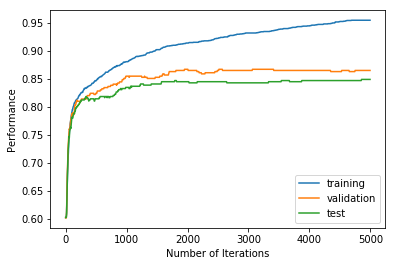

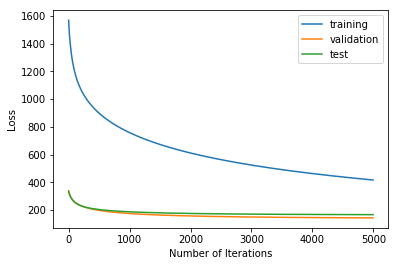

Top 10 positive thetas are:
['trumps', 'turnbull', 'north', 'australia', 'donald', 'debate', 'says', 'trade', 'tax', 'ban']
Top 10 negative thetas are:
['victory', 'hillary', 'breaking', 'supporter', 'just', 'watch', 'black', 'voter', 'rally', 'america']


In [36]:
part6b()

## Helper Functions for Part 7

In [39]:
def clfGenerateData(wordBase, targetSet):
    xy = np.zeros([len(wordBase)+1, (len(targetSet['real'])+len(targetSet['fake']))])
    n = 0
    for rof in ['real', 'fake']:
        for news in targetSet[rof]:
            for word in news.split(' '):
                if word in wordBase:
                    xy[wordBase.index(word),n] = 1
            if rof == 'real':
                xy[-1,n] = 1
            n += 1
    return xy

In [40]:
def clfPerformance(x, y, clf, print_output = False,report = "test set"):
    predict = clf.predict(x)
    result = 0.
    for i in range(len(predict)):
        if predict[i] == y[i]:
            result+=1
            
    if print_output:
        print "Performance on "+report+ ": " +str(result)+"/"+str(len(predict))
    
    return result/len(predict)

## Part 7

In [49]:
def part7(seed = 0):
    np.random.seed(seed)
    
    fakeNews, realNews = getNews()
    trainingSet, validationSet, testSet = dataSetSplit(fakeNews, realNews)
    wordBase = generateWordBase(trainingSet)
    
    training_xy = clfGenerateData(wordBase, trainingSet)
    validation_xy = clfGenerateData(wordBase, validationSet)
    test_xy = clfGenerateData(wordBase, testSet)
    
    for max_depth in range(10,200,10):
        clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = max_depth)
        clf = clf.fit(training_xy[:-1,:].T, training_xy[-1,:].T)
        print "Maximum Depth is: ",max_depth 
        print clfPerformance(validation_xy[:-1,:].T, validation_xy[-1,:], clf, print_output = True,report = "validation set")
    
    clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 1000)
    clf = clf.fit(training_xy[:-1,:].T, training_xy[-1,:].T)
    
    print "\nChoose maximum depth = ", 100
    print clfPerformance(validation_xy[:-1,:].T, validation_xy[-1,:], clf, print_output = True,report = "validation set")
    print clfPerformance(test_xy[:-1,:].T, test_xy[-1,:], clf, print_output = True,report = "test set")
    
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names = wordBase, filled=True, rounded=True, special_characters=True)  
    graph = graphviz.Source(dot_data)

    return graph

In [50]:
graph = part7()

Maximum Depth is:  10
Performance on validation set: 359.0/490
0.732653061224
Maximum Depth is:  20
Performance on validation set: 375.0/490
0.765306122449
Maximum Depth is:  30
Performance on validation set: 374.0/490
0.763265306122
Maximum Depth is:  40
Performance on validation set: 379.0/490
0.773469387755
Maximum Depth is:  50
Performance on validation set: 375.0/490
0.765306122449
Maximum Depth is:  60
Performance on validation set: 377.0/490
0.769387755102
Maximum Depth is:  70
Performance on validation set: 373.0/490
0.761224489796
Maximum Depth is:  80
Performance on validation set: 382.0/490
0.779591836735
Maximum Depth is:  90
Performance on validation set: 373.0/490
0.761224489796
Maximum Depth is:  100
Performance on validation set: 386.0/490
0.787755102041
Maximum Depth is:  110
Performance on validation set: 382.0/490
0.779591836735
Maximum Depth is:  120
Performance on validation set: 376.0/490
0.767346938776
Maximum Depth is:  130
Performance on validation set: 379.0/4

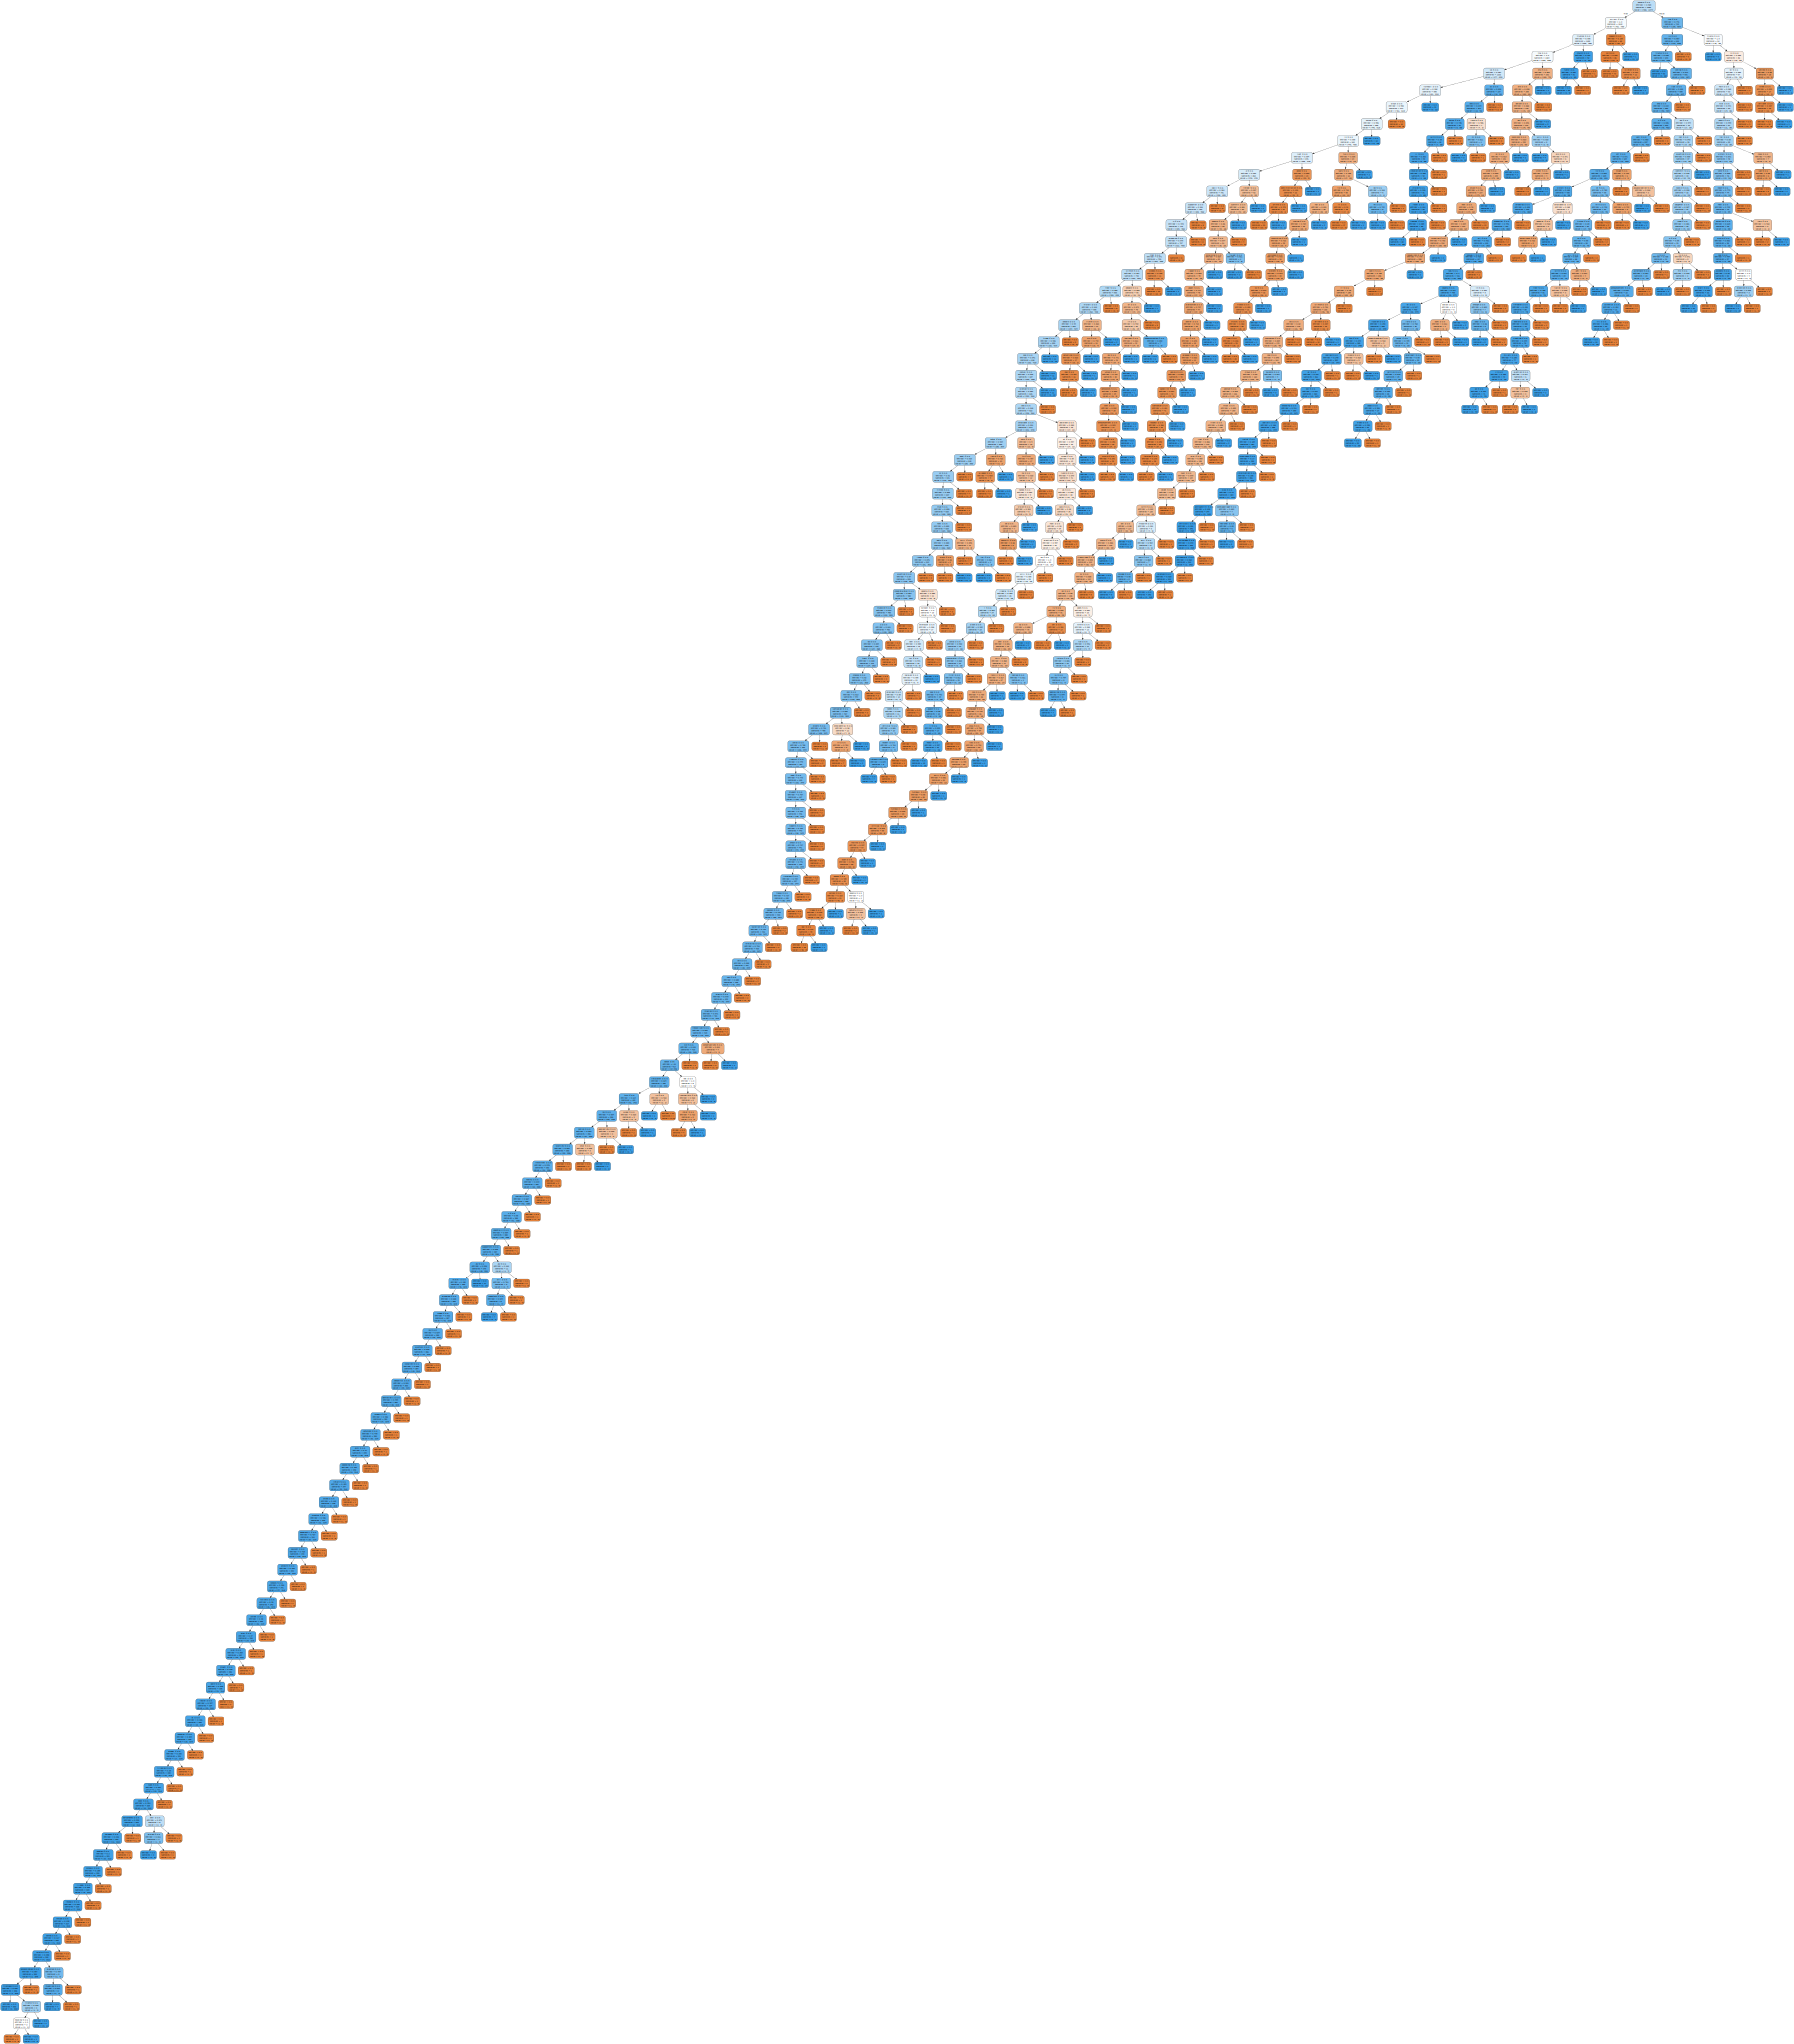

In [48]:
graph

## Part 8